In [1]:
import sys
import numpy
import pandas
import matplotlib
import seaborn
import scipy

print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(numpy.__version__))
print('Pandas: {}'.format(pandas.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Seaborn: {}'.format(seaborn.__version__))
print('Scipy: {}'.format(scipy.__version__))

Python: 3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
Numpy: 1.16.2
Pandas: 0.23.4
Matplotlib: 2.2.3
Seaborn: 0.9.0
Scipy: 1.2.1


In [2]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset from the csv file using pandas
data = pd.read_csv('creditcard.csv')

In [4]:
# Start exploring the dataset
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [5]:
# Print the shape of the data
data = data.sample(frac=0.5, random_state = 1)
print(data.shape)
print(data.describe())

# V1 - V28 are the results of a PCA Dimensionality reduction to protect user identities and sensitive features

(142404, 31)
                Time             V1             V2             V3  \
count  142404.000000  142404.000000  142404.000000  142404.000000   
mean    94636.653149       0.005281       0.002965       0.003540   
std     47530.885474       1.941833       1.650699       1.499189   
min         0.000000     -56.407510     -72.715728     -33.680984   
25%     54070.750000      -0.917749      -0.597082      -0.883249   
50%     84580.000000       0.022735       0.067128       0.180715   
75%    139223.250000       1.315881       0.808052       1.027217   
max    172784.000000       2.454930      21.467203       4.069865   

                  V4             V5             V6             V7  \
count  142404.000000  142404.000000  142404.000000  142404.000000   
mean        0.003841       0.000792      -0.004870      -0.001985   
std         1.414823       1.366677       1.324166       1.211335   
min        -5.560118     -42.147898     -26.160506     -41.506796   
25%        -0.844659

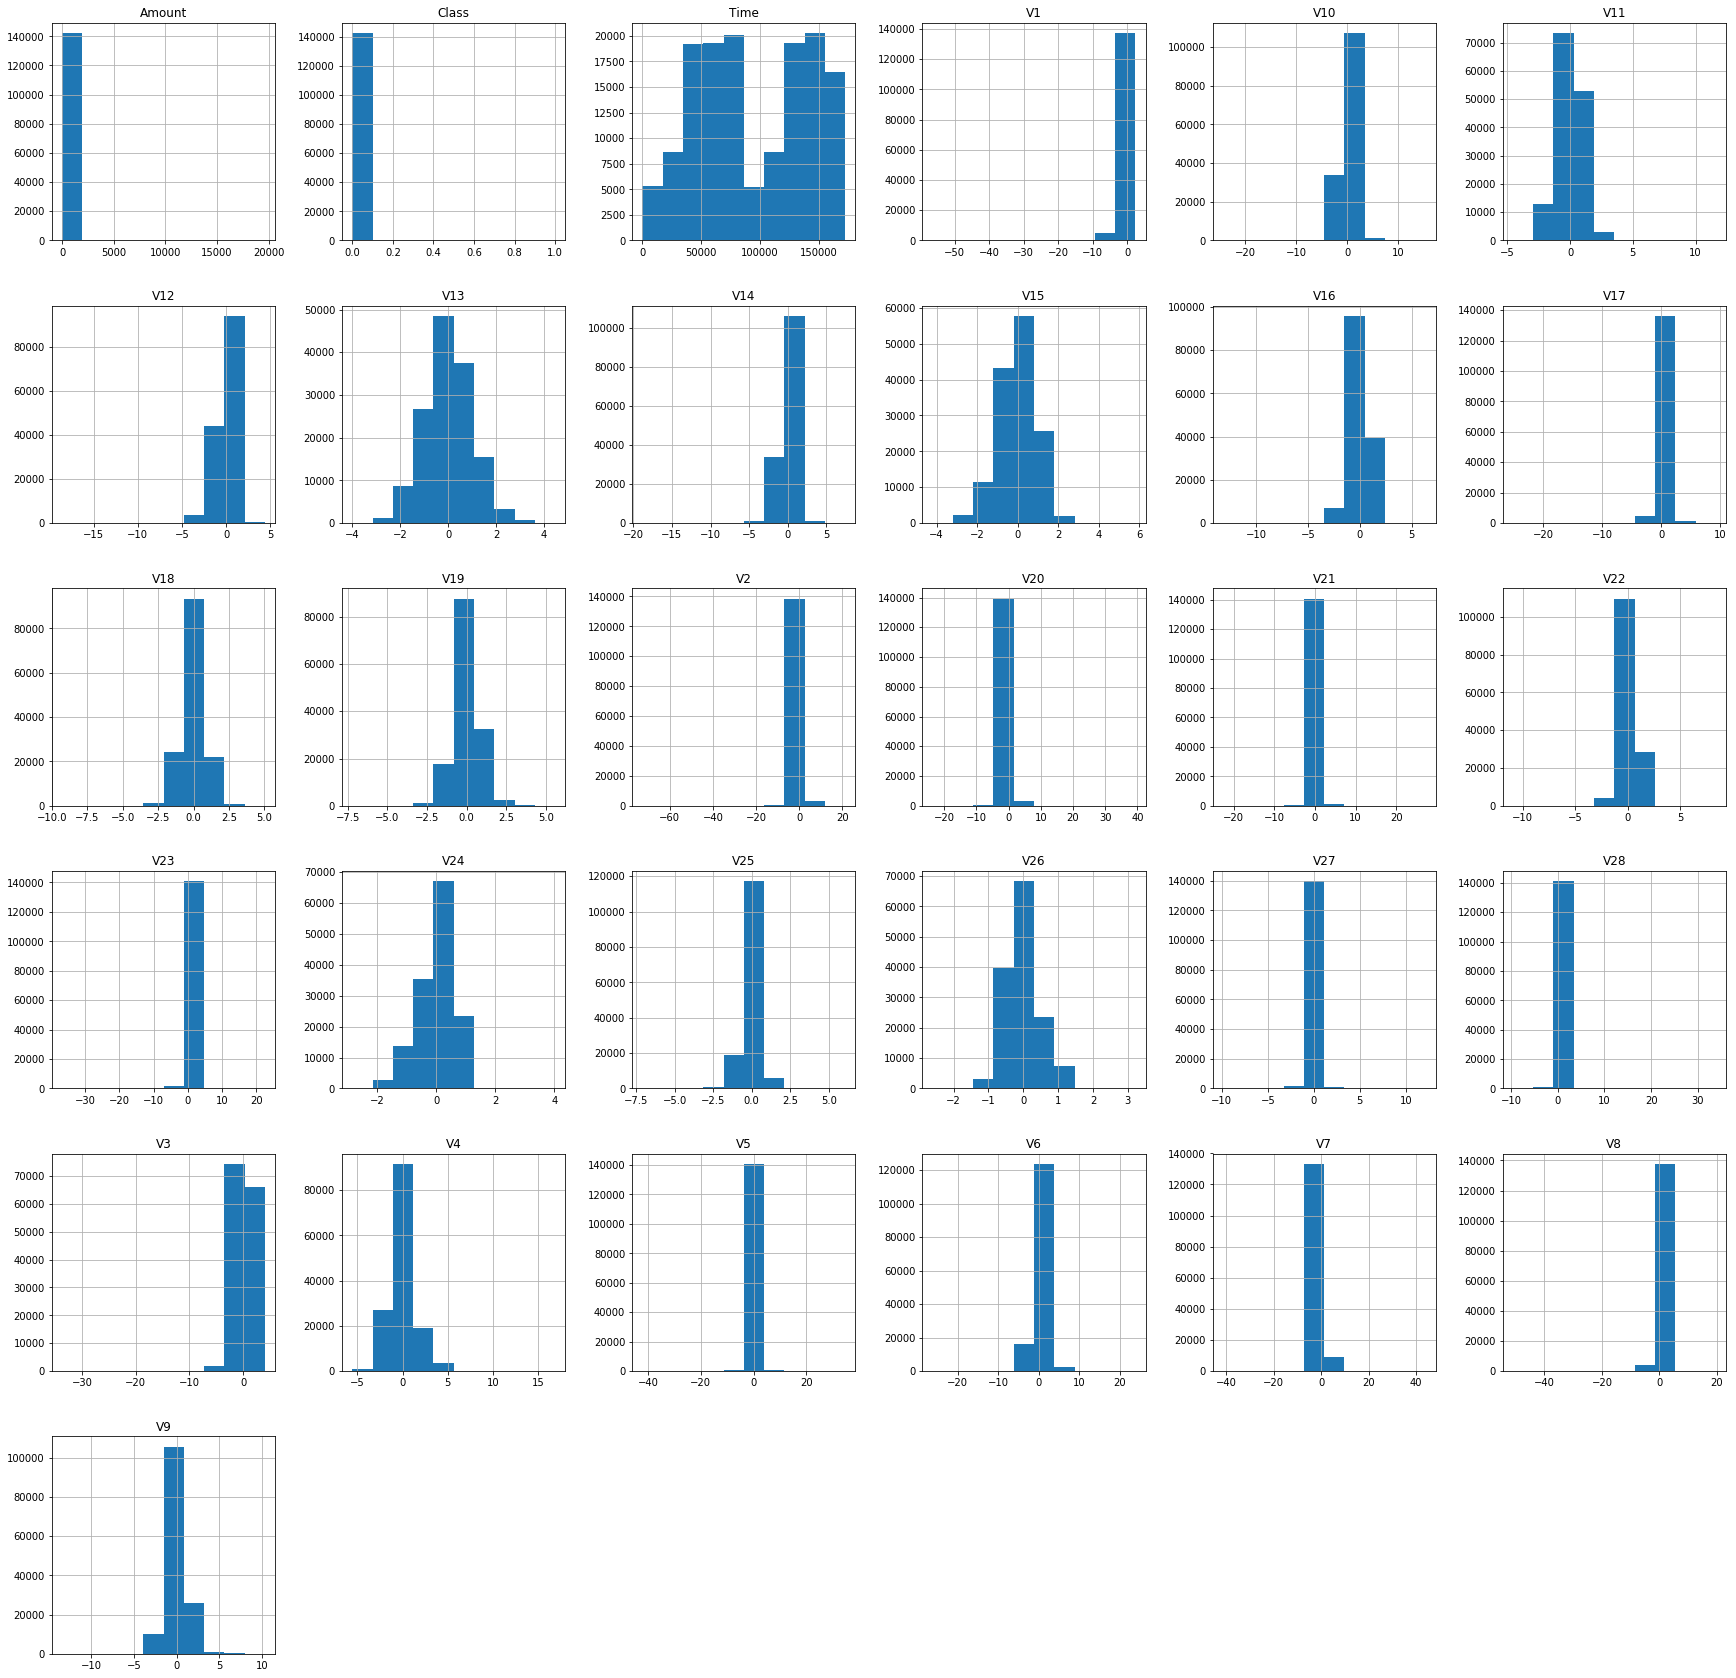

In [6]:
# Plot histograms of each parameter 
data.hist(figsize = (30, 30))
plt.show()

In [7]:
# Determine number of fraud cases in dataset

Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))

0.0015966014193575613
Fraud Cases: 227
Valid Transactions: 142177


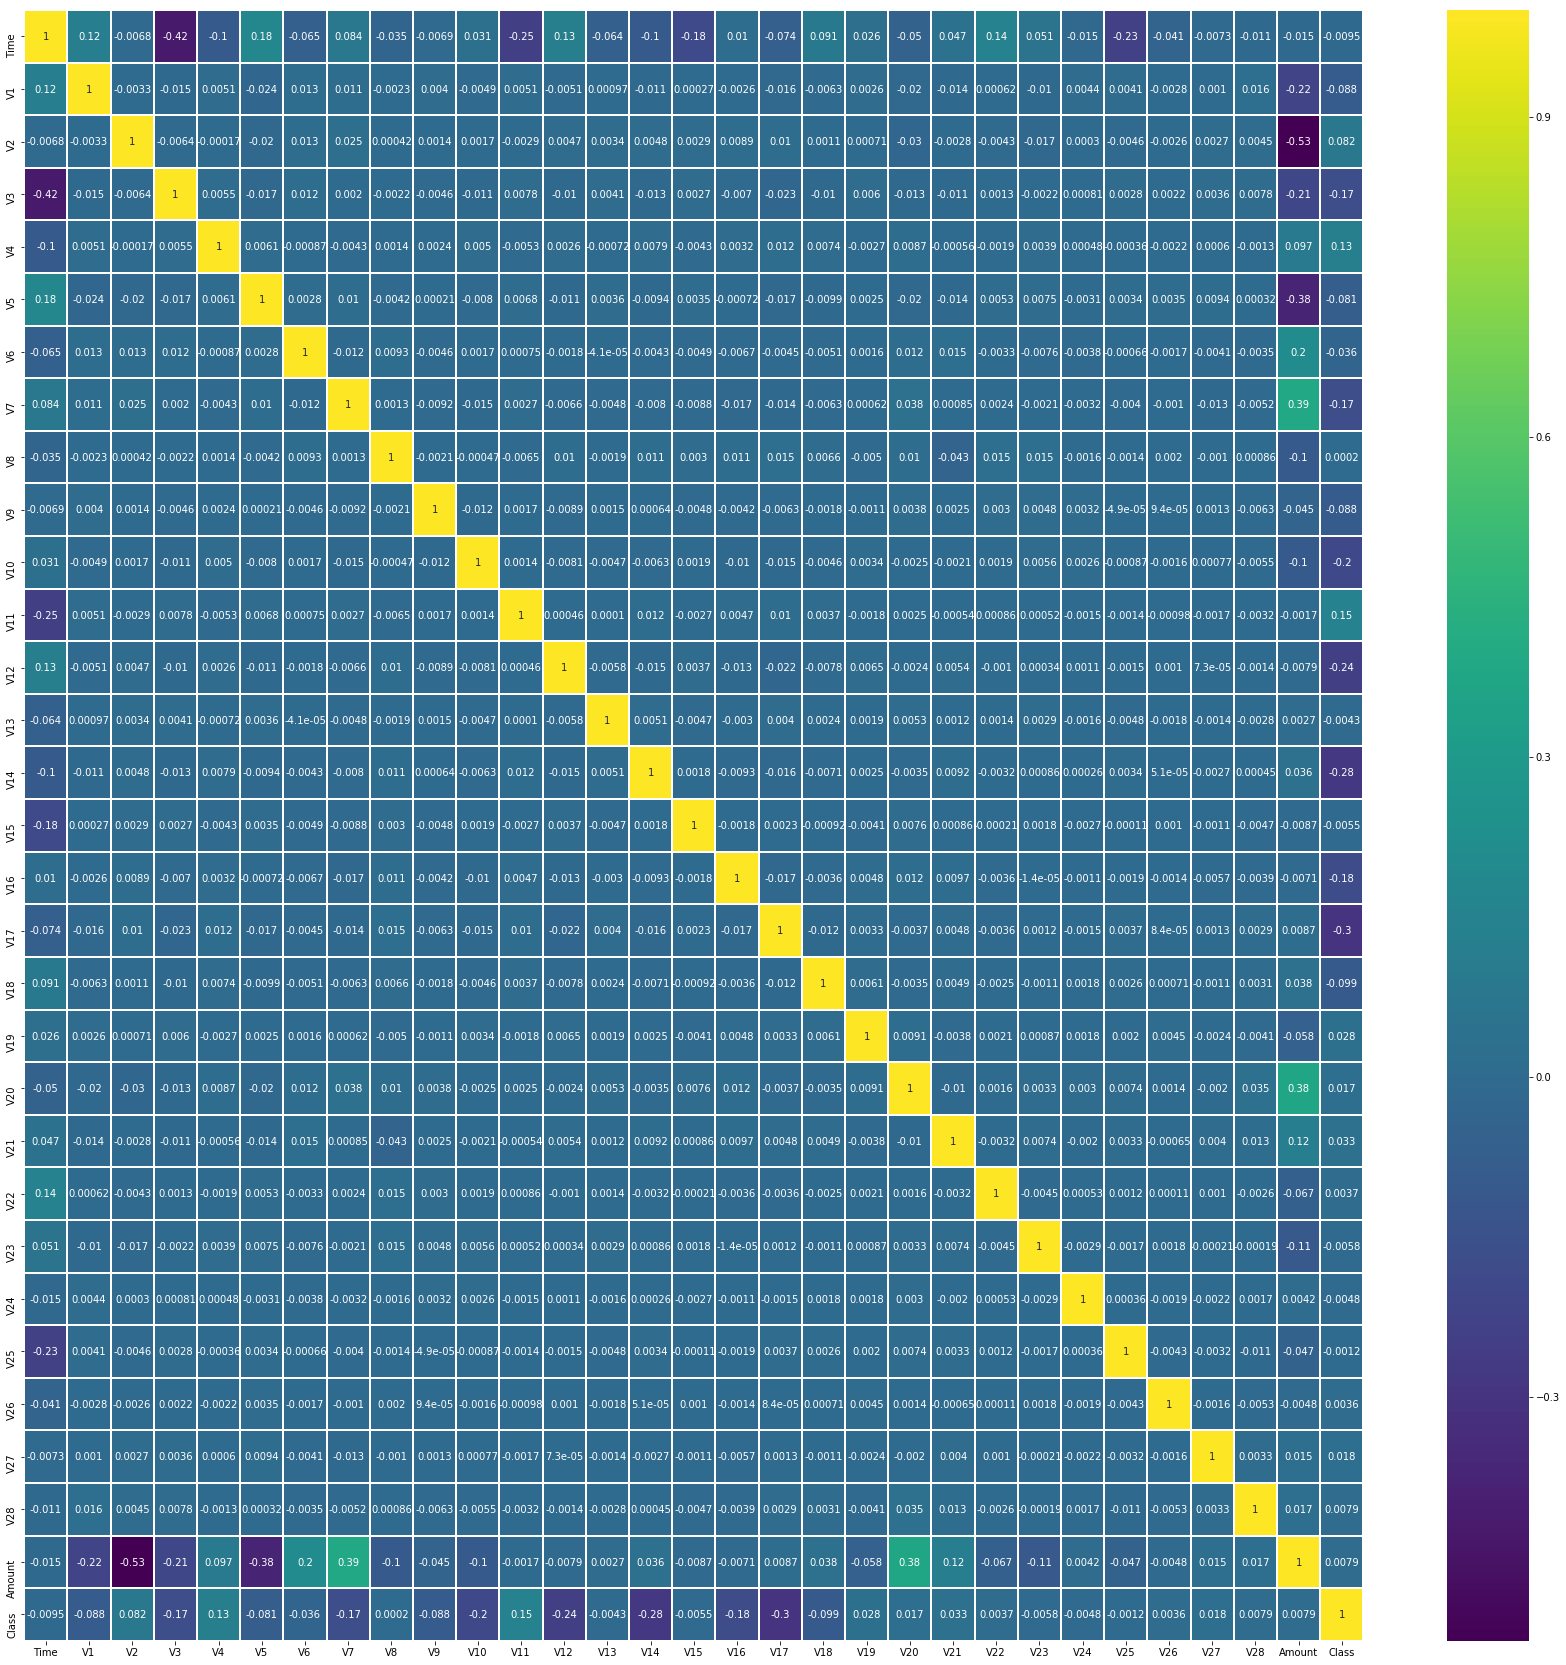

In [8]:
# Correlation matrix
corrmat = data.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corrmat,cmap='viridis',annot=True,linewidths=1.0,)

In [9]:
# Get all the columns from the dataFrame
columns = data.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]

# Store the variable we'll be predicting on
target = "Class"

X = data[columns]
Y = data[target]

# Print shapes
print(X.shape)
print(Y.shape)

(142404, 30)
(142404,)


Unsupervised Outlier Detection

Now that we have processed our data, we can begin deploying our machine learning algorithms. We will use the following techniques:

Local Outlier Factor (LOF)

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood.

Isolation Forest Algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [10]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# define random states
state = 1

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction)}

In [11]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(Fraud)


for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))

C:\Users\vibhu\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\vibhu\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest: 317
0.9977739389342996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142177
           1       0.30      0.30      0.30       227

   micro avg       1.00      1.00      1.00    142404
   macro avg       0.65      0.65      0.65    142404
weighted avg       1.00      1.00      1.00    142404

Local Outlier Factor: 439
0.9969172214263644
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142177
           1       0.04      0.04      0.04       227

   micro avg       1.00      1.00      1.00    142404
   macro avg       0.52      0.52      0.52    142404
weighted avg       1.00      1.00      1.00    142404



<Figure size 648x504 with 0 Axes>